In [1]:
import sys
import json
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
current_dir = Path.cwd()
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print('done')

done


In [38]:
from src.utils.save_data import save_df_parquet_safe, load_df_parquet_safe
from src.utils.plot_graphs import plot_beautiful

In [4]:
# loading the master_df
path = project_root / 'data' / 'processed' / 'merge' / 'aligned_avw_merged.parquet'
avw_merged = load_df_parquet_safe(path=str(path))
avw_merged.head()

,Time,words,text_concat,h_ratio,v_ratio,_neutral,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,...,mouthStretchRight,mouthUpperUpLeft,mouthUpperUpRight,noseSneerLeft,noseSneerRight,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent,speaker
0,0.0,"[We're, starting]",We're starting,0.463844,0.012997,3.112116e-06,0.015592,0.025971,0.023290,0.123947,...,0.000443,0.000025,0.000022,4.540787e-07,4.185384e-07,0.0373,0.00,0.00,False,None
1,0.5,"[now., [*]]",now. [*],0.418074,-0.048988,2.558370e-06,0.017408,0.037184,0.007811,0.137800,...,0.000918,0.000023,0.000030,2.511999e-07,3.643879e-07,0.0533,169.25,11.45,False,A
2,1.0,None,,0.465044,-0.030748,3.958608e-07,0.008864,0.010406,0.016732,0.179330,...,0.000332,0.000189,0.000269,2.899701e-06,1.134860e-07,0.0006,0.00,0.00,True,A
3,1.5,"[So, welcome]",So welcome,0.505119,-0.055033,3.260218e-07,0.012983,0.016629,0.008106,0.186212,...,0.000170,0.000070,0.000103,2.350217e-06,9.529118e-08,0.0593,179.94,14.03,False,A
4,2.0,"[to, the]",to the,0.590369,-0.050514,5.068692e-07,0.016363,0.028436,0.006705,0.117622,...,0.001666,0.000455,0.000476,4.304491e-06,2.317813e-07,0.0646,237.84,56.17,False,A


In [5]:
type(avw_merged.loc[avw_merged['speaker'] == 'B', 'words'])

pandas.core.series.Series

In [6]:
type(avw_merged['words'][0])

list

In [7]:
# total no of words
totalwords = 0
for words in avw_merged.loc[avw_merged['speaker'] == 'B', 'words']:
    if words and words != None:
        totalwords += len(words)
    else:
        continue

In [8]:
# let's count the filler words
cnt = 0
for words in avw_merged.loc[avw_merged['speaker'] == 'B', 'words']:
    if words and words != None:
        for word in words:
            if word == '[*]':
                cnt += 1
    else:
        continue

In [9]:
print(f"Total no of words used by the user: {totalwords}")

Total no of words used by the user: 1552


In [10]:
print(f"Total no of filler words by user: {cnt}")

Total no of filler words by user: 209


In [ ]:
print(f"percentage of filler words: {(cnt/totalwords)*100}%")

percentage of filler words: 13.466494845360824%


I am trying to create a couple of features 1st one which keeps track of the filler words and one another this one keeps track of pauses.

In [32]:
# let's first make a copy of the dataframe
avw_merged_copy = avw_merged.copy()

In [26]:
avw_merged_copy.loc[avw_merged['speaker'] == 'B', 'words'].index

Index([  23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
       ...
       1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194],
      dtype='int64', length=1053)

In [27]:
# let's count the filler words
f_percent_pr = []
cnt = 0
for words in avw_merged_copy.loc[avw_merged['speaker'] == 'B', 'words']:
    if words and words != None:
        for word in words:
            if word == '[*]':
                cnt += 1        
        f_percent_pr.append((cnt/totalwords)*100)
    else:
        f_percent_pr.append((cnt/totalwords)*100)

In [28]:
f_percent_pr = pd.Series(f_percent_pr, name='filler_percentage')

In [29]:
f_percent_pr

0        0.064433
1        0.064433
2        0.064433
3        0.064433
4        0.064433
          ...    
1048    13.466495
1049    13.466495
1050    13.466495
1051    13.466495
1052    13.466495
Name: filler_percentage, Length: 1053, dtype: float64

In [33]:
avw_merged_copy.loc[avw_merged_copy.loc[avw_merged['speaker'] == 'B', 'words'].index, 'filler_percentage'] = f_percent_pr.values

In [34]:
avw_merged_copy['filler_percentage']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1259   NaN
1260   NaN
1261   NaN
1262   NaN
1263   NaN
Name: filler_percentage, Length: 1264, dtype: float64

In [36]:
avw_merged_copy['filler_percentage'].ffill(inplace=True)
avw_merged_copy['filler_percentage'].bfill(inplace=True)

In [37]:
avw_merged_copy['filler_percentage']

0        0.064433
1        0.064433
2        0.064433
3        0.064433
4        0.064433
          ...    
1259    13.466495
1260    13.466495
1261    13.466495
1262    13.466495
1263    13.466495
Name: filler_percentage, Length: 1264, dtype: float64

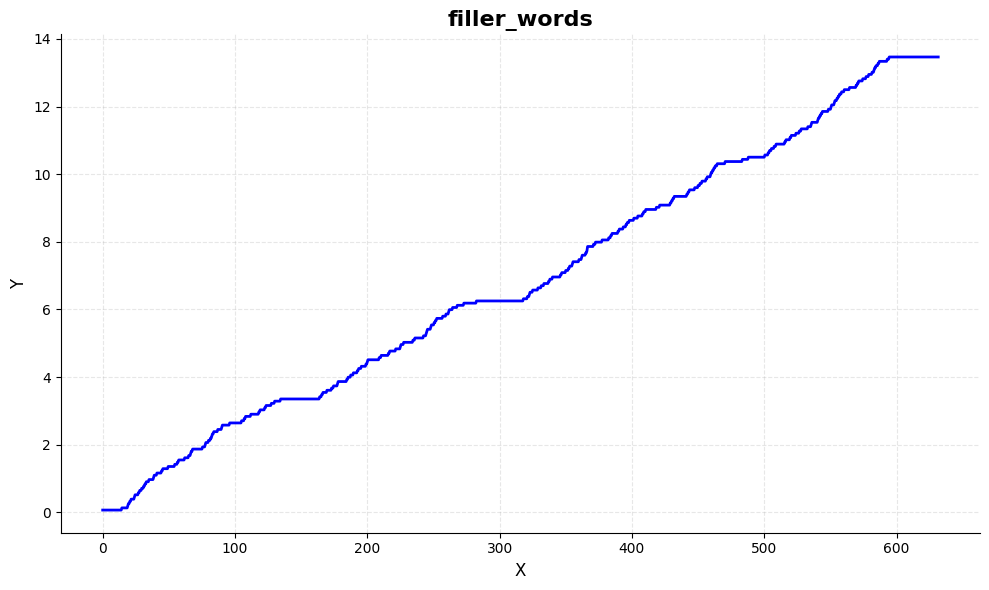

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'filler_words'}, xlabel='X', ylabel='Y'>)

In [115]:
plot_beautiful(x=avw_merged_copy['Time'], y=avw_merged_copy['filler_percentage'], title='filler_words')

I think we did it we created the first feature which was the filler percentage for the user and you can see how it increases with time

Let's move on to the next one, which is the pause_percentage calulation

In [44]:
avw_merged_copy['is_silent'].unique()

array([False,  True])

In [102]:
(avw_merged_copy['text_concat'] == '') & (avw_merged_copy['speaker'] == 'B')

0       False
1       False
2       False
3       False
4       False
        ...  
1259    False
1260    False
1261    False
1262    False
1263    False
Length: 1264, dtype: bool

In [103]:
pauses = avw_merged_copy.loc[(avw_merged_copy['text_concat'] == '') & (avw_merged_copy['speaker'] == 'B')]

In [104]:
pauses

,Time,words,text_concat,h_ratio,v_ratio,_neutral,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,...,mouthUpperUpLeft,mouthUpperUpRight,noseSneerLeft,noseSneerRight,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent,speaker,filler_percentage
24,12.0,None,,0.728435,-0.142492,3.132464e-07,0.045179,0.040908,0.009608,0.118403,...,0.000126,0.000091,7.311042e-06,5.223714e-07,0.0231,152.76,2.12,False,B,0.064433
30,15.0,None,,0.593893,-0.193699,5.971576e-07,0.062908,0.074055,0.005985,0.086427,...,0.003938,0.004427,6.452660e-06,5.226813e-07,0.0655,157.90,16.20,False,B,0.128866
36,18.0,None,,0.484392,0.003739,4.071718e-07,0.004079,0.003867,0.036102,0.319405,...,0.000545,0.000767,5.757051e-06,5.222055e-07,0.0252,511.84,4.33,False,B,0.128866
40,20.0,None,,0.546542,-0.038629,3.590792e-07,0.005254,0.006796,0.032924,0.307509,...,0.000489,0.000703,4.068359e-06,4.419209e-07,0.0010,0.00,0.00,True,B,0.257732
55,27.5,None,,0.490090,-0.032755,5.500617e-07,0.005637,0.006906,0.084726,0.241090,...,0.002427,0.002132,7.318318e-06,1.113463e-06,0.0043,0.00,0.00,True,B,0.579897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,576.0,None,,0.454673,-0.072017,2.277565e-07,0.001308,0.001434,0.113143,0.612043,...,0.006290,0.007758,4.396444e-06,5.401757e-07,0.1628,163.31,13.17,False,B,12.822165
1159,579.5,None,,0.444614,-0.032941,1.235616e-07,0.000822,0.001126,0.319367,0.607522,...,0.002194,0.002803,1.450525e-05,1.557612e-07,0.0000,0.00,0.00,True,B,12.951031
1173,586.5,None,,0.500530,-0.099797,2.035024e-07,0.001848,0.001884,0.133064,0.432855,...,0.000004,0.000005,9.937831e-07,6.988680e-08,0.0044,0.00,0.00,True,B,13.273196
1184,592.0,None,,0.501852,-0.062575,2.714621e-07,0.002535,0.003157,0.037799,0.372288,...,0.002142,0.001884,2.413889e-06,6.806368e-07,0.0912,155.43,11.86,False,B,13.337629


In [105]:
pauses.shape

(122, 63)

In [106]:
avw_merged_copy['Time'].iloc[-1]

np.float64(631.5)

In [107]:
start = 0
pause_percent_pr = []
for i in range(len(pauses)):
    start += 0.5
    pause_percent_pr.append((start/avw_merged_copy['Time'].iloc[-1].item())*100)
    

In [108]:
pause_percent_pr = pd.Series(pause_percent_pr, name='pause_percent_pr')
pause_percent_pr

0      0.079177
1      0.158353
2      0.237530
3      0.316706
4      0.395883
         ...   
117    9.342835
118    9.422011
119    9.501188
120    9.580364
121    9.659541
Name: pause_percent_pr, Length: 122, dtype: float64

In [109]:
avw_merged_copy.loc[avw_merged_copy.loc[((avw_merged_copy['text_concat'] == '') & (avw_merged_copy['speaker'] == 'B'))].index, 'pause_percent_pr'] = pause_percent_pr.values

In [97]:
avw_merged_copy.columns

Index(['Time', 'words', 'text_concat', 'h_ratio', 'v_ratio', '_neutral',
       'browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft',
       'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight',
       'eyeBlinkLeft', 'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight',
       'eyeLookInLeft', 'eyeLookInRight', 'eyeLookOutLeft', 'eyeLookOutRight',
       'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 'eyeSquintRight',
       'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen',
       'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight',
       'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLeft',
       'mouthLowerDownLeft', 'mouthLowerDownRight', 'mouthPressLeft',
       'mouthPressRight', 'mouthPucker', 'mouthRight', 'mouthRollLower',
       'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper',
       'mouthSmileLeft', 'mouthSmileRight', 'mouthStretchLeft',
       'mouthStretchRight', 'mouthUpperUpLeft', 'mo

In [110]:
avw_merged_copy['pause_percent_pr']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1259   NaN
1260   NaN
1261   NaN
1262   NaN
1263   NaN
Name: pause_percent_pr, Length: 1264, dtype: float64

In [111]:
avw_merged_copy['pause_percent_pr'].ffill(inplace=True)
avw_merged_copy['pause_percent_pr'].bfill(inplace=True)

In [112]:
avw_merged_copy['pause_percent_pr']

0       0.079177
1       0.079177
2       0.079177
3       0.079177
4       0.079177
          ...   
1259    9.659541
1260    9.659541
1261    9.659541
1262    9.659541
1263    9.659541
Name: pause_percent_pr, Length: 1264, dtype: float64

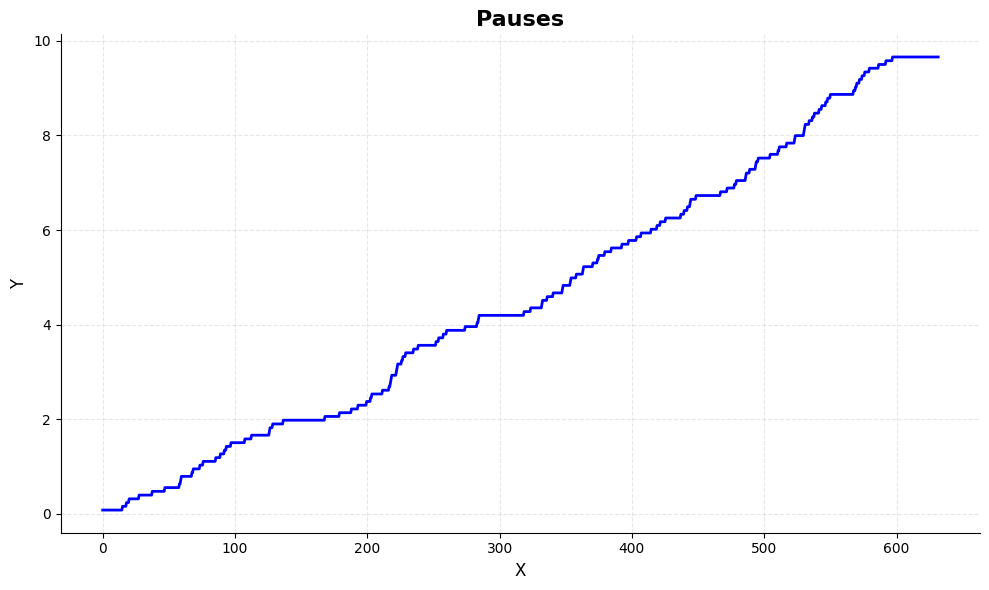

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Pauses'}, xlabel='X', ylabel='Y'>)

In [114]:
plot_beautiful(x=avw_merged_copy['Time'], y=avw_merged_copy['pause_percent_pr'], title="Pauses")

Pauses are also done